In [38]:
# Imports
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt

# Make sure you have pytorch installed
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

# Make sure you place L96_model in the same folder as the notebook! 
from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

# Latex
plt.rcParams["text.usetex"] = True

# Seaborn
import seaborn as sns

In [39]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

In [40]:
# L96 parameters
time_steps = 20000
forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32. This is the full coupled model
W = L96(8, 32, F=forcing)

In [ ]:
# The effect of Y on X is `xy_true` (C_k term)
X_true, _, _, xy_true = W.run(dt, T, store=True, return_coupling=True)

# Change the data type to `float32` in order to avoid doing type conversions later on
X_true, xy_true = X_true.astype(np.float32), xy_true.astype(np.float32) # Shape is (20001, 8)

In [42]:
# Number of time steps for validation
val_size = 4000

# Training Data split
X_true_train = X_true[:-val_size, :]  # Flatten because we first use single input as a sample
subgrid_tend_train = xy_true[:-val_size, :]

# Test Data split (his test set is my idea of a validation set)
X_true_test = X_true[-val_size:, :]
subgrid_tend_test = xy_true[-val_size:, :]

In [43]:
# Number of sample in each batch
# You can play with this number if you are having memory issues
BATCH_SIZE = 2000

In [44]:
# Create torch datasets and dataloader. This is done through the "Data" object from pytorch
local_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_train, -1)), # Matrix is now a 1D vector size (n,)
    torch.from_numpy(np.reshape(subgrid_tend_train, -1)), # Pairing input & target
)

local_loader = Data.DataLoader( # Wraps an iterable around the dataset
    dataset=local_dataset, batch_size=BATCH_SIZE, shuffle=True # No data augm., but shuffling
)

In [45]:
# Create torch test datasets and dataloader.
local_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_test, -1)),
    torch.from_numpy(np.reshape(subgrid_tend_test, -1)),
)

local_loader_test = Data.DataLoader(
    dataset=local_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

X (State):
 tensor([ 4.1728, -1.5047,  8.8898,  ...,  5.4477, -4.0861,  0.3179])

Y (Subgrid Tendency):
 tensor([-6.7729,  0.4764, -7.8355,  ..., -5.4671, -0.0774, -1.0472])


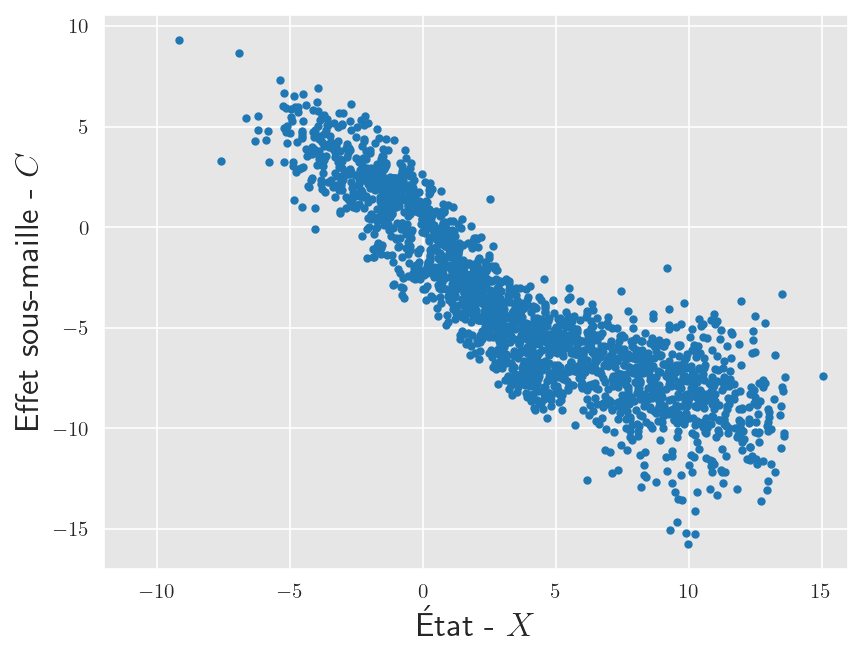

In [46]:
# Data visualization example (vizualization of the truth dataset)
# Iterating over the data to get one batch
data_iterator = iter(local_loader)
X_iter, subgrid_tend_iter = next(data_iterator) # Rappel: subgrid_tend_iter is xy_true is C_k term

print("X (State):\n", X_iter)
print("\nY (Subgrid Tendency):\n", subgrid_tend_iter)

sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
plt.figure(dpi=150)
plt.plot(X_iter, subgrid_tend_iter, ".")
plt.xlabel(r"État - $X$", fontsize=16)
plt.ylabel(r"Effet sous-maille - $C$", fontsize=16)
plt.xlim([-12, 16])

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/viz_1.png',dpi=500)

### Architecture du modèle linéaire

In [47]:
# Simple regression model
class LinearRegression(nn.Module): # LinearRegression hérite de nn.Module
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 1)  # A single input and a single output (modèle à une seule couche). 

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.linear1(x)
        return x

# On va devoir faire un entraînement avec cette unique couche et sur toutes les batch pour obtenir la relation linéaire  
# https://stackoverflow.com/questions/64054961/what-does-pytorchs-nn-linearx-y-return
# https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-model
# Pythorch's layers list: https://docs.pytorch.org/docs/stable/nn.html 
# Pytorch's nn.Linear: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

In [48]:
# Instanciation du modèle. On crée un objet linear_network contenant la couche (linear1) et ses poids
linear_network = LinearRegression()
linear_network # Inspection (affiche les paramètres du modèle)

LinearRegression(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
)

### Architecture du réseau de neurones simple à une dimension

In [49]:
# Simple Neural Network
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)  # 1 inputs
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 1)  # 1 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [50]:
nn_network = NN()
nn_network

NN(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [51]:
# Tests sur les deux modèles avec un input aléatoire
net_input = torch.randn(1, 1)
out_linear = linear_network(net_input)
out_nn = nn_network(net_input)
print(f"The output of the random input from the linear network is: {out_linear.item():.4f}")
print(f"The output of the random input from the nn is: {out_nn.item():.4f}")

The output of the random input from the linear network is: 1.2266
The output of the random input from the nn is: 0.1427


In [52]:
# MSE loss function
loss_fn = torch.nn.MSELoss() # Compare prediction with true subgrid term

In [53]:
# Load an input and output pair from the data loader
X_tmp = next(iter(local_loader)) # Temporary, 1 iter. X_tmp[0] is X_true, X_tmp[1] is subgrid_tend (C_k term)

# Predict the output
y_tmp_linear = linear_network(torch.unsqueeze(X_tmp[0], 1)) # Y pas pour variables rapides mais pour C_k
y_tmp_nn = nn_network(torch.unsqueeze(X_tmp[0], 1))

# Calculate the MSE loss
loss_linear = loss_fn(y_tmp_linear, torch.unsqueeze(X_tmp[1], 1))
print(f"Linear network MSE Loss: {loss_linear.item():.4f}")

loss_nn = loss_fn(y_tmp_nn, torch.unsqueeze(X_tmp[1], 1))
print(f"NN MSE Loss: {loss_nn.item():.4f}")

Linear network MSE Loss: 99.7602
NN MSE Loss: 35.3304


In [54]:
learning_rate = 0.003

In [55]:
# Montrer l'ajustement des poids sur le modèle linéaire simple
optimizer_linear = optim.Adam(linear_network.parameters(), lr=learning_rate) 
print("Before backward pass (weights): \n", list(linear_network.parameters())[0].data.numpy()) # Couche d'entrée et ses poids
print("Before backward pass (biases): \n", list(linear_network.parameters())[1].data.numpy())

loss_linear.backward(retain_graph=True)
optimizer_linear.step()

print("\nAfter backward pass: \n", list(linear_network.parameters())[0].data.numpy())

# https://www.geeksforgeeks.org/deep-learning/adam-optimizer/
# Pythorch's Adam: https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
# Matlab's sgdm: https://www.mathworks.com/help/deeplearning/ref/trainingoptions.html#bu59f0q_sep_mw_6dcd8e56-4de5-497d-a48e-0f6f804f57f6_head

Before backward pass (weights): 
 [[0.6589745]]
Before backward pass (biases): 
 [0.53658974]

After backward pass: 
 [[0.6559745]]


In [56]:
optimizer_nn = optim.Adam(nn_network.parameters(), lr=learning_rate)

In [57]:
def train_model(network, criterion, loader, optimizer): # Criterion = loss function, Loader = data loader
    """Train the network for one epoch"""
    network.train()

    train_loss = 0
    for batch_x, batch_y in loader:
        # Get predictions
        if len(batch_x.shape) == 1:
            # This if block is needed to add a dummy dimension if our inputs are 1D
            # (where each number is a different sample)
            # On a nn.Linear(in_features, out_features) mais PyTorch attend aussi un batch de ces entrées, 
            # donc (batch_size, in_features) -> (batch_size, 1)
            prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
        else:
            prediction = network(batch_x)

        # Compute the loss
        loss = criterion(prediction, batch_y)
        train_loss += loss.item()

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute the gradients and update the weights
        loss.backward()
        optimizer.step() # Gradient Descent

    return train_loss / len(loader) # Perte moyenne pour une époque

In [58]:
def test_model(network, criterion, loader):
    """Test the network"""
    network.eval()  # Evaluation mode (important when having dropout layers) ??

    test_loss = 0
    with torch.no_grad(): # Aucun calcul de gradient -> pas d'optimisation
        for batch_x, batch_y in loader:
            # Get predictions
            if len(batch_x.shape) == 1:
                # This if block is needed to add a dummy dimension if our inputs are 1D
                # (where each number is a different sample)
                prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
            else:
                prediction = network(batch_x)

            # Compute the loss
            loss = criterion(prediction, batch_y)
            test_loss += loss.item()

        # No weights updating because test set

        # Get an average loss for the entire dataset
        test_loss /= len(loader)

    return test_loss

# Validation (test) set: doesn't adjust model parameters/hyperparameters
# "A validation [test] dataset is a sample of data held back from training your model that is 
# used to give an estimate of model skill while tuning model’s hyperparameters."
# "The evaluation of a model skill on the training dataset would result in a biased score"
# Source: https://machinelearningmastery.com/difference-test-validation-dataset/

In [59]:
def fit_model(network, criterion, optimizer, train_loader, test_loader, n_epochs):
    """Train and validate the network"""
    train_losses, test_losses = [], []
    for epoch in range(1, n_epochs + 1):
        train_loss = train_model(network, criterion, train_loader, optimizer)
        test_loss = test_model(network, criterion, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    print("Training complete!")
    return train_losses, test_losses

In [60]:
# Epochs refer to the number of times we iterate over the entire training data during training.
n_epochs = 25 # Default 25

In [61]:
# Training the linear model
train_loss_linear, test_loss_linear = fit_model(
    linear_network, loss_fn, optimizer_linear, local_loader, local_loader_test, n_epochs
)

Training complete!


In [62]:
# Training the 1D NN model
train_loss_nn, test_loss_nn = fit_model(
    nn_network, loss_fn, optimizer_nn, local_loader, local_loader_test, n_epochs
)

Training complete!


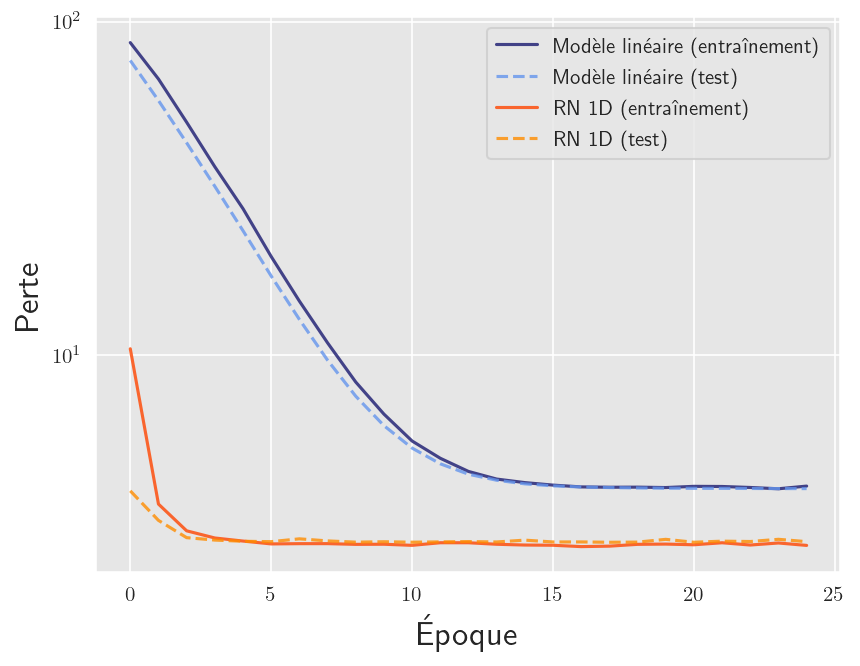

In [63]:
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
plt.figure(dpi=150)

plt.plot(train_loss_linear, label="Modèle linéaire (entraînement)", color='midnightblue', alpha=0.8)
plt.plot(test_loss_linear, linestyle="--", label="Modèle linéaire (test)", color='cornflowerblue', alpha=0.8)

plt.plot(train_loss_nn, label="RN 1D (entraînement)", color='orangered', alpha=0.8)
plt.plot(test_loss_nn, linestyle="--", label="RN 1D (test)", color='darkorange', alpha=0.8)

plt.legend()
plt.xlabel("Époque", fontsize=16)
plt.ylabel("Perte", fontsize=16)
plt.yscale("log")
#plt.title("Loss vs Iteration")
#plt.show();

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/l1_loss_initial_25.png',dpi=500)


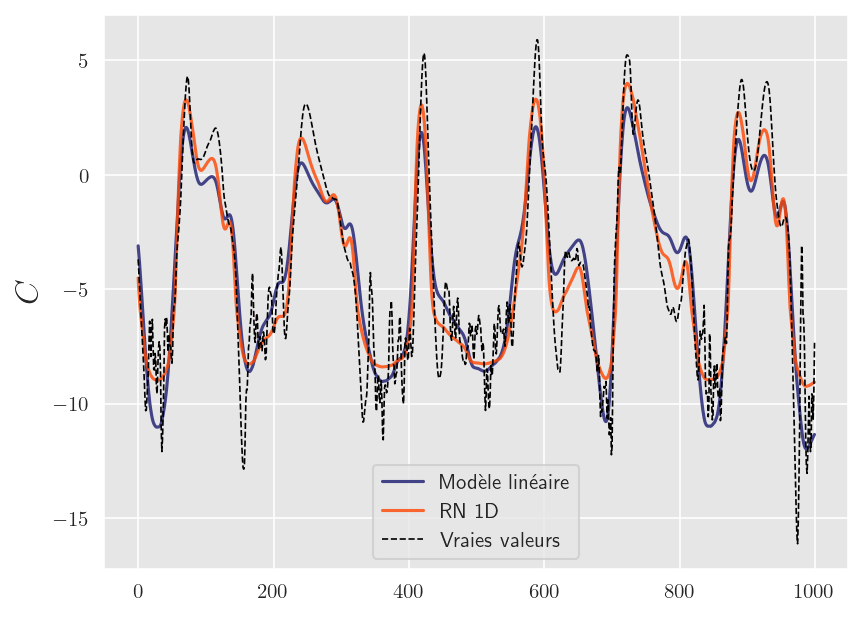

In [ ]:
# Faire des prédictions avec nos modèles entraînés (on reprend le test set)
predictions_linear = linear_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1) # Prédictions des C_k pour tous les X_1 de test (où X_k=X_8)
    # Convertit en tenseur et lui donne bonne dimension (N,1)
)
predictions_nn = nn_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1)
)

sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
plt.figure(dpi=150)
plt.plot(
    predictions_linear.detach().numpy()[0:1000], label="Modèle linéaire", color='midnightblue', alpha=0.8 # 1000 premières prédictions
)
plt.plot(predictions_nn.detach().numpy()[0:1000], label="RN 1D", color='orangered', alpha=0.8)
plt.plot(subgrid_tend_test[:1000, 1], label="Vraies valeurs", color="k", linestyle="--", linewidth=0.8)
plt.legend(fontsize=10);
#plt.xlabel("Numéro de valeur")
plt.ylabel(r"$C$",fontsize=16)

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/l1_predict_initial.png',dpi=500)

# Detach: "method to create a new tensor that is disconnected from the current computational graph", so that no gradient will be calculated for it
# https://docs.pytorch.org/docs/stable/generated/torch.Tensor.detach.html

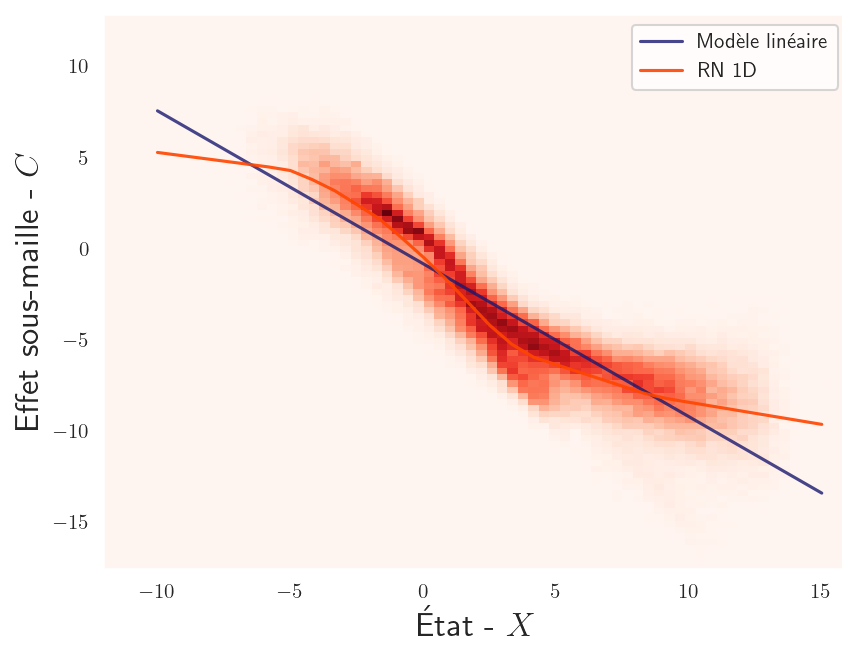

In [65]:
# Visualisation de la forme de la fonction apprise par les deux modèles
X_points = torch.from_numpy(np.linspace(-10, 15, 31).astype(np.float32)) # On reprend ici l'intervalle utilisé pour la visualisation initiale

linear_pred = linear_network(torch.unsqueeze(X_points, 1)).detach().numpy() # Prédictions

nn_pred = nn_network(torch.unsqueeze(X_points, 1)).detach().numpy()

sns.set_style("darkgrid", {"axes.facecolor": "1"})
plt.figure(dpi=150)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds") # Histo 2D!

plt.plot(X_points, linear_pred, "-", label="Modèle linéaire", color='midnightblue', alpha=0.8)
plt.plot(X_points, nn_pred, "-", label="RN 1D", color='orangered', alpha=0.9)

plt.legend()
plt.xlim([-12, 16])
plt.xlabel(r"État - $X$", fontsize=16)
plt.ylabel(r"Effet sous-maille - $C$", fontsize=16)
#plt.show();

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/l1_forme_fonction_initial.png',dpi=500)

In [66]:
# Now lets look at a nonlocal model...

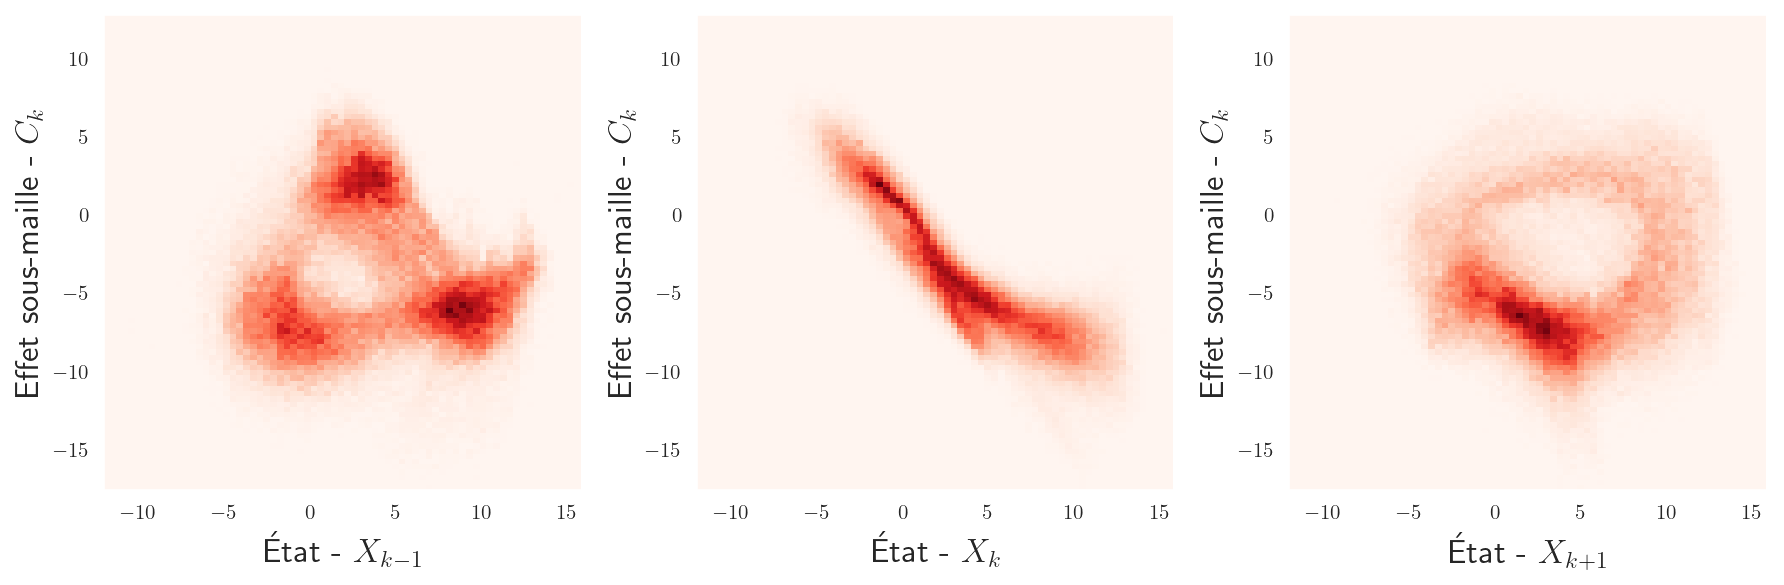

In [67]:
sns.set_style("darkgrid", {"axes.facecolor": "1"})
plt.figure(figsize=(12, 4), dpi=150)

plt.subplot(131)
plt.hist2d(
    np.reshape(np.roll(X_true, -1, axis=1), -1), # On a le pas de temps suivant de X, pour mêmes valeurs de xy_true
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("État - $X_{k-1}$", fontsize=16) # Erreur? (k+1)
plt.ylabel("Effet sous-maille - $C_k$", fontsize=16)

plt.subplot(132)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds")
plt.xlim([-12, 16])
plt.xlabel("État - $X_{k}$", fontsize=16) 
plt.ylabel("Effet sous-maille - $C_k$", fontsize=16)

plt.subplot(133)
plt.hist2d(
    np.reshape(np.roll(X_true, 1, axis=1), -1),
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("État - $X_{k+1}$", fontsize=16) 
plt.ylabel("Effet sous-maille - $C_k$", fontsize=16)

plt.tight_layout()

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/relations_initial.png',dpi=500)

# Roll: https://numpy.org/doc/stable/reference/generated/numpy.roll.html#numpy.roll (-1 pour dernier)
# Reshape: "One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions"

In [68]:
# Training Dataset
# ----------------
nlocal_data_train = Data.TensorDataset(
    torch.from_numpy(X_true_train),
    torch.from_numpy(subgrid_tend_train),
)
nlocal_loader_train = Data.DataLoader(
    dataset=nlocal_data_train, batch_size=BATCH_SIZE, shuffle=True
)


# Test Dataset
# ------------
nlocal_data_test = Data.TensorDataset(
    torch.from_numpy(X_true_test), torch.from_numpy(subgrid_tend_test)
)
nlocal_loader_test = Data.DataLoader(
    dataset=nlocal_data_test, batch_size=BATCH_SIZE, shuffle=True
)

### Architecture du réseau de neurones simple à huit dimension

In [69]:
class NonLocal_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [70]:
nonlocal_nn_network = NonLocal_NN()

In [71]:
optimizer_nonlocal_nn = optim.Adam(
    nonlocal_nn_network.parameters(), lr=learning_rate
)

In [72]:
n_epochs = 120 # Default 120
train_loss_nonlocal, test_loss_nonlocal = fit_model(
    nonlocal_nn_network,
    loss_fn,
    optimizer_nonlocal_nn,
    nlocal_loader_train,
    nlocal_loader_test,
    n_epochs,
)

Training complete!


### MSE finale

In [73]:
print(f"MSE finale (test sample) pour le modèle linéaire est: {test_loss_linear[-1]:.4f}")
print(f"MSE finale (test sample) pour le RN 1D est: {test_loss_nn[-1]:.4f}")
print(f"MSE finale (test sample) pour le RN 8D est: {test_loss_nonlocal[-1]:.4f}")

MSE finale (test sample) pour le modèle linéaire est: 3.9694
MSE finale (test sample) pour le RN 1D est: 2.7514
MSE finale (test sample) pour le RN 8D est: 2.8228


### R-Squared score

In [ ]:
# Méthode 1: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
import sklearn
from sklearn.metrics import r2_score
r_squared_linear_1 = r2_score(subgrid_tend_test[:, 1], predictions_linear.detach().numpy()) # .detach().numpy()
#print(f"R² pour le modèle linéaire est: {r_squared_linear_1:.4f}")

# Méthode 2:  (from SO, pas bon)
import statsmodels.api as sm
r_squared_linear_2 = sm.OLS(subgrid_tend_test[:, 1], predictions_linear.detach().numpy()).fit()
#print(r_squared_linear_2.rsquared)

# Méthode 3: https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml (résultat identique à la méthode 1)
def get_r2(y,yhat):
    """ Calcualte the coef. of determination (R^2) """
    ybar = np.mean(y)
    return 1 - (np.sum((y-yhat)**2))/(np.sum((y-ybar)**2))
r_squared_linear_3 = get_r2(subgrid_tend_test[:, 1], predictions_linear.squeeze().detach().numpy())
#print(f"R² pour le modèle linéaire est: {r_squared_linear_3:.4f}")

# https://www.geeksforgeeks.org/machine-learning/ml-r-squared-in-regression-analysis/
# https://en.wikipedia.org/wiki/Coefficient_of_determination 
# The value of R-square lies between 0 to 1. Where we get R-square equals 1 when the model perfectly fits the data.
# Also known as the coefficient of determination 
# It explains unaccounted variability in the dependent y after predicting these values from an independent variable in the model
# Is the Pearson correlation coefficient squared only when used on simple linear regression
# Comparing Y_pred to Y_true

# Usage de la méthode 1
## Modèle linéaire
r_squared_linear = r2_score(subgrid_tend_test[:, 1], predictions_linear.detach().numpy()) # .detach().numpy()
print(f"R² pour le modèle linéaire est: {r_squared_linear:.4f}")

## RN 1D
r_squared_1D = r2_score(subgrid_tend_test[:, 1], predictions_nn.detach().numpy()) # .detach().numpy()
print(f"R² pour le RN 1D est: {r_squared_1D:.4f}")

## RN 8D
# Faire les prédictions
predictions_nonlocal = nonlocal_nn_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1)
)
# Calculer le score
r_squared_8D = r2_score(subgrid_tend_test[:, 1], predictions_nonlocal.detach().numpy()) # .detach().numpy()
print(f"R² pour le RN 8D est: {r_squared_8D:.4f}")

R² pour le modèle linéaire est: 0.8028
0.8915403
R² pour le modèle linéaire est: 0.8028
(4000,)
(4000, 1)


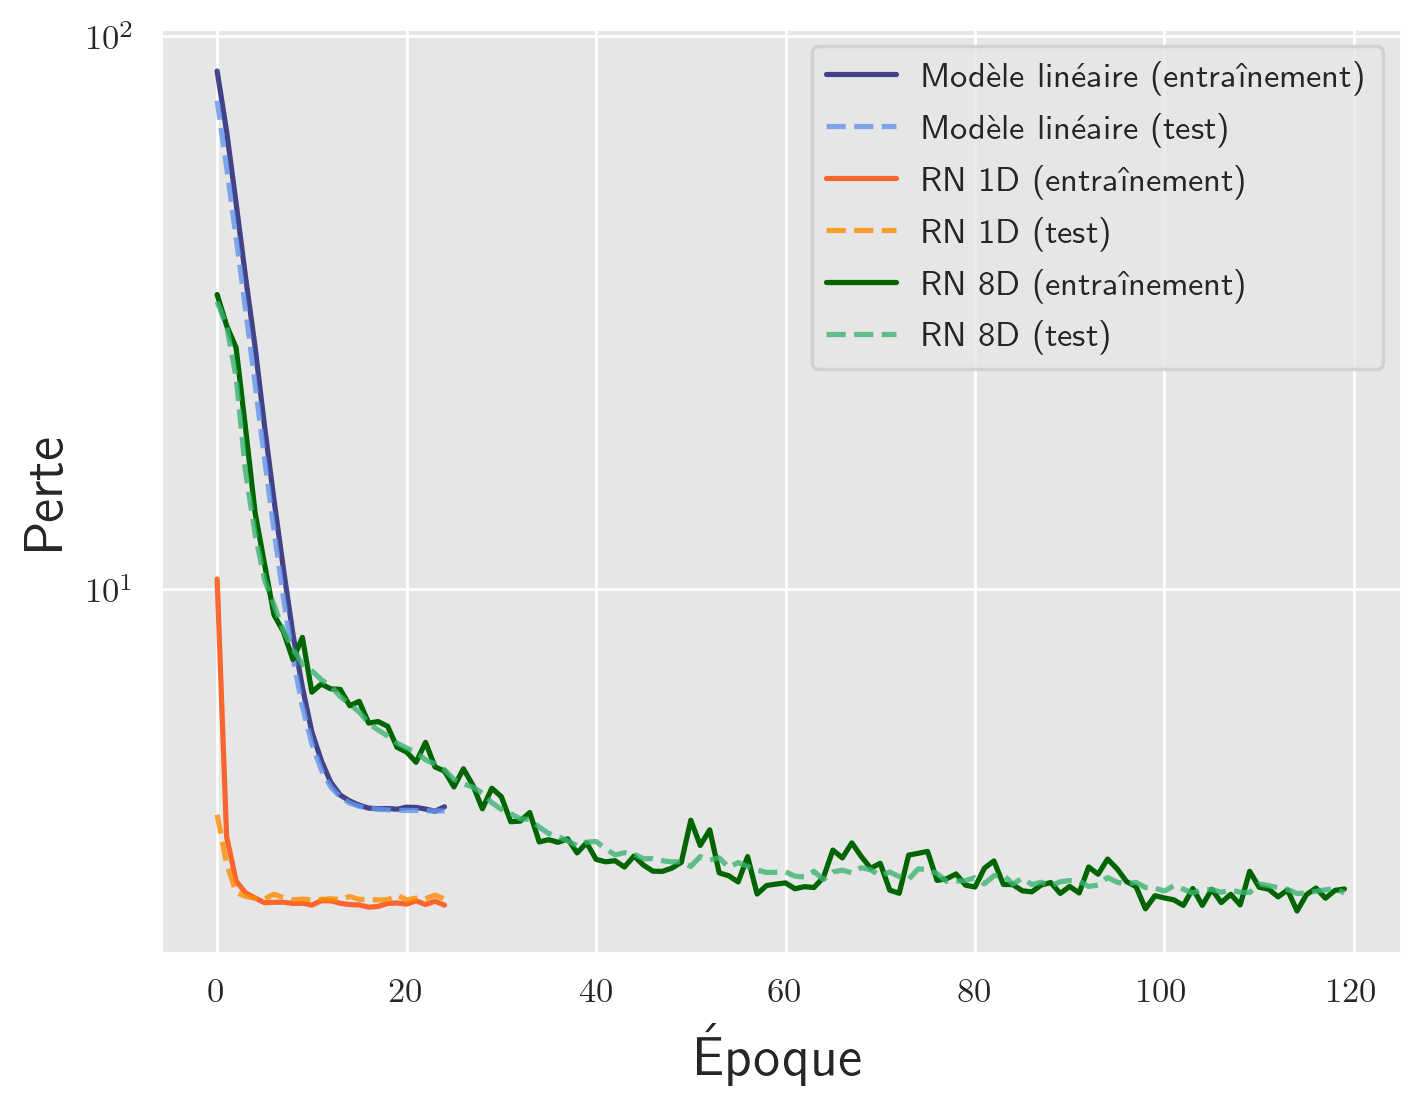

In [ ]:
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

plt.figure(dpi=250)

plt.plot(train_loss_linear, label="Modèle linéaire (entraînement)", color='midnightblue', alpha=0.8)
plt.plot(test_loss_linear, linestyle="--", label="Modèle linéaire (test)", color='cornflowerblue', alpha=0.8)

plt.plot(train_loss_nn, label="RN 1D (entraînement)", color='orangered', alpha=0.8)
plt.plot(test_loss_nn, linestyle="--", label="RN 1D (test)", color='darkorange', alpha=0.8)

plt.plot(train_loss_nonlocal, label="RN 8D (entraînement)", color='darkgreen')
plt.plot(test_loss_nonlocal, linestyle="--", label="RN 8D (test)", color='mediumseagreen', alpha=0.8)

plt.legend()
plt.xlabel("Époque", fontsize=16)
plt.ylabel("Perte", fontsize=16)
plt.yscale("log")
#plt.title("Loss vs Epochs")
#plt.grid()
#plt.show();

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/l18_loss_initial.png',dpi=500)

In [ ]:
# Save the trained networks
save_path = "non_local_NN.pth"
torch.save(nonlocal_nn_network.state_dict(), save_path)

save_path = "local_NN.pth"
torch.save(nn_network.state_dict(), save_path)

save_path = "linear.pth"
torch.save(linear_network.state_dict(), save_path)